In [1]:
#libraries
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Load Data

In [4]:
col_names = ["date", "value"]
df = pd.read_csv("Electricity_Prodiction.csv",
                 names = col_names, header = 0, parse_dates = [0])
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['date'])
df.head()


,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


#plot graphs

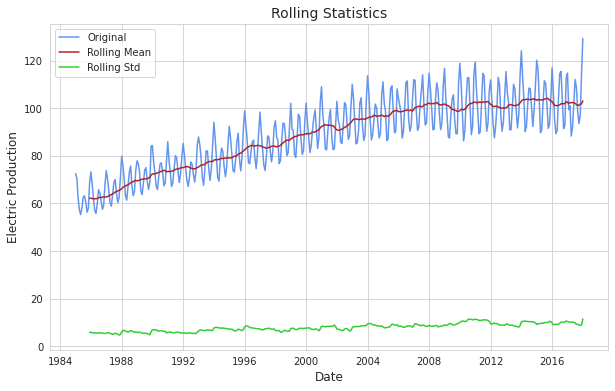

In [5]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

#Check Stationarity

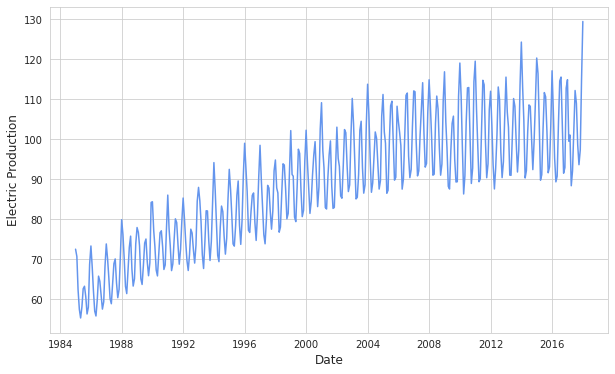

In [6]:
plt.figure(figsize = (10,6))
plt.plot(df['value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

#Above plot shows upward trend over the time.
Plot histogram of frequency (value) column

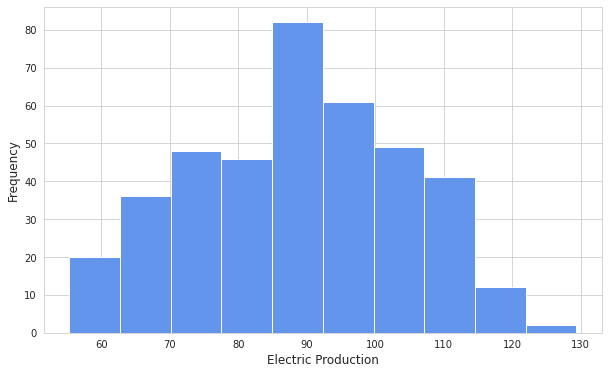

In [7]:
plt.figure(figsize = (10,6))
plt.hist(df['value'], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

In [8]:
#print data shape and split data in two parts
print("Data Shape: {}".format(df.shape))
value_1 = df[0:199]
value_2 = df[200:397]

Data Shape: (397, 1)


Mean is

In [9]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))

Mean of value_1: 77.497
Mean of value_2: 100.258


Variance of splitted data 

In [10]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_1: 123.226
Variance of value_2: 91.677


***Augmented Dickey-Fuller Test***

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

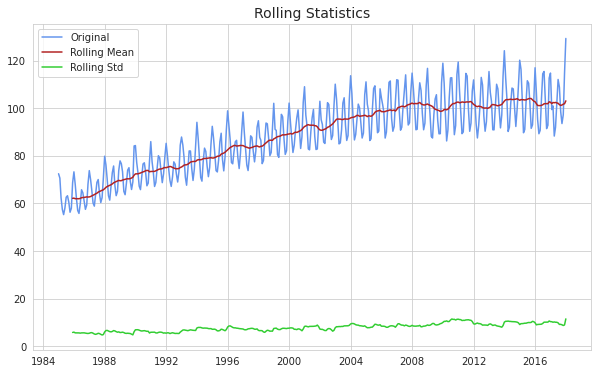

ValueError: ignored

In [13]:
def adfuller_test(ts, window = 12):    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',label='Original')
    mean = plt.plot(movingAverage, color='firebrick',label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)    
    adf = adfuller(ts, autolag='AIC')    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12)

**Logarithmic Transformation with Box-Cox**
The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

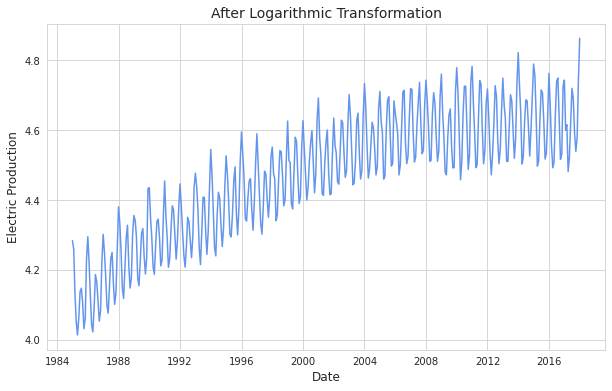

In [14]:
df_log_scaled = df
df_log_scaled['value'] = boxcox(df_log_scaled['value'], lmbda=0.0)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Logarithmic Transformation", size = 14)
plt.show()

**Removing Trend with Moving Average**

A time series with a trend is called non-stationary.

An identified trend can be modeled. Once modeled, it can be removed from the time series dataset. This is called detrending the time series.

If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be trend stationary.

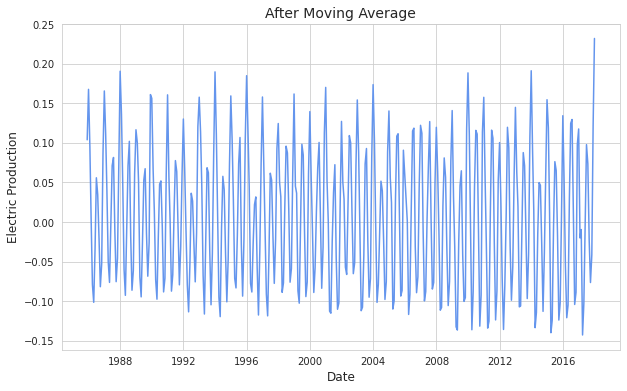

In [15]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

**Exponential Decay Transformation**

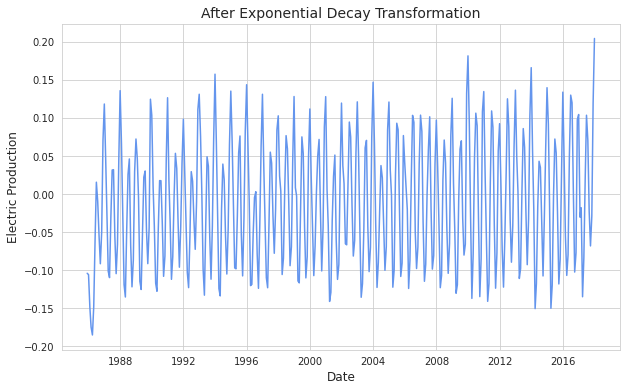

In [16]:
df_log_scaled_ma_ed = df_log_scaled_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_lsma_sub_df_lsma_ed = df_log_scaled_ma - df_log_scaled_ma_ed
plt.figure(figsize = (10,6))
plt.plot(df_lsma_sub_df_lsma_ed - df_log_scaled_ma_ed, color='cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Exponential Decay Transformation", size = 14)
plt.show()

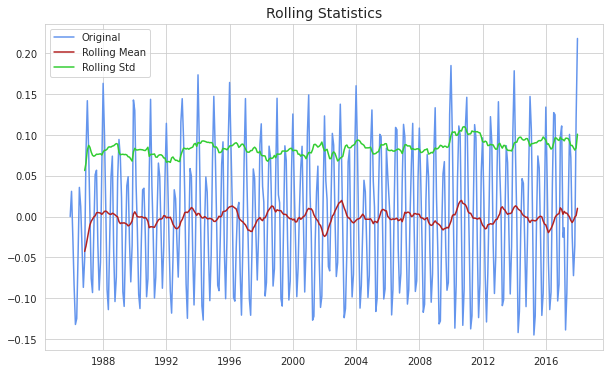

ValueError: ignored

In [17]:
#Test stationarity again
adfuller_test(df_lsma_sub_df_lsma_ed, window = 12)

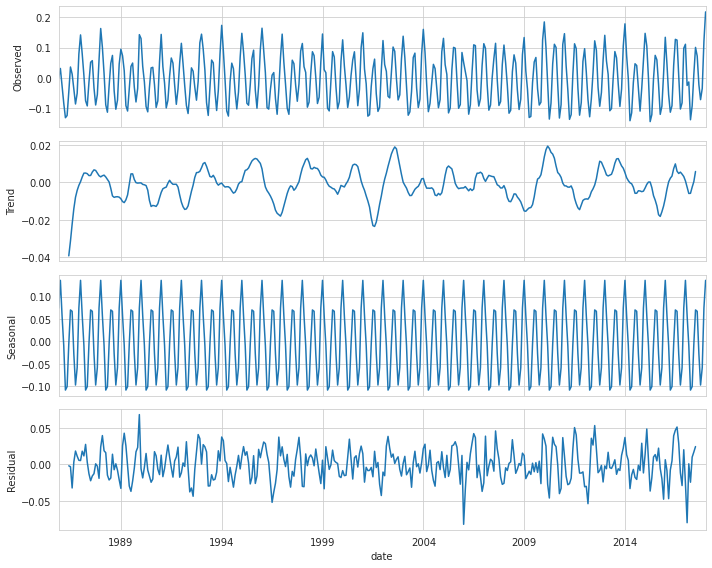

In [18]:
rcParams['figure.figsize']=10,8
df_seasonal_decompose = seasonal_decompose(df_lsma_sub_df_lsma_ed, 
                                           model='duplicative')
df_seasonal_decompose.plot()
plt.show()


Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

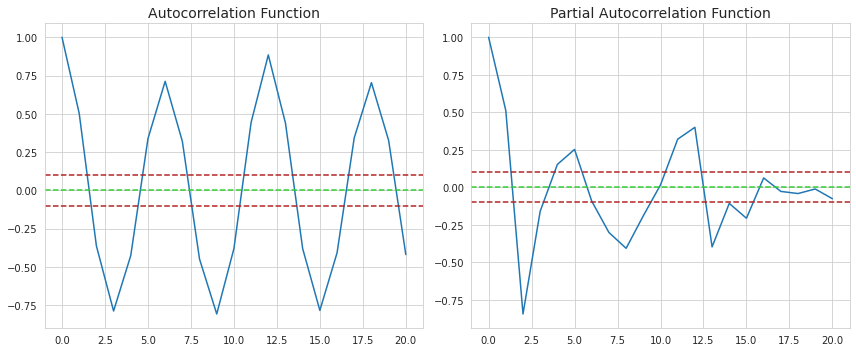

In [19]:
auto_c_f = acf(df_lsma_sub_df_lsma_ed, nlags=20)
partial_auto_c_f = pacf(df_lsma_sub_df_lsma_ed, nlags=20, method='ols')

fig, axs = plt.subplots(1, 2, figsize =(12,5))

plt.subplot(121)
plt.plot(auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)            

plt.subplot(122)
plt.plot(partial_auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)
            
plt.tight_layout() 

**Forecasting Models**

In [20]:
values = DataFrame(df_lsma_sub_df_lsma_ed.values)
persistence_df = concat([values.shift(1), values], axis=1)
persistence_df.columns = ['t-1', 't+1']
per_values = persistence_df.values

train = per_values[1:len(per_values)-10] 
test = per_values[len(per_values)-10:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

def persistence(x):
    return x

predictions = []
for i in X_test:
    y_pred = persistence(i)
    predictions.append(y_pred)

persistence_score = mean_squared_error(y_test, predictions)
print('Persistence MSE: {}'.format(round(persistence_score,4)))

Persistence MSE: 0.0084


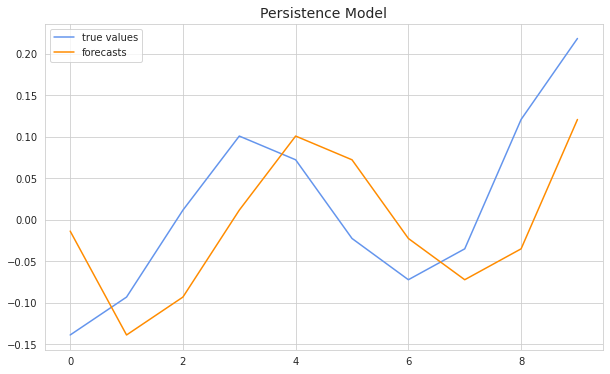

In [21]:
plt.figure(figsize = (10,6))
plt.plot(y_test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("Persistence Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

**Autoregression Model**

In [22]:
ar_values = df_lsma_sub_df_lsma_ed.values
train = ar_values[1:len(ar_values)-10] 
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order=(2,1,0))
AR_model = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, predictions)
print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.0212


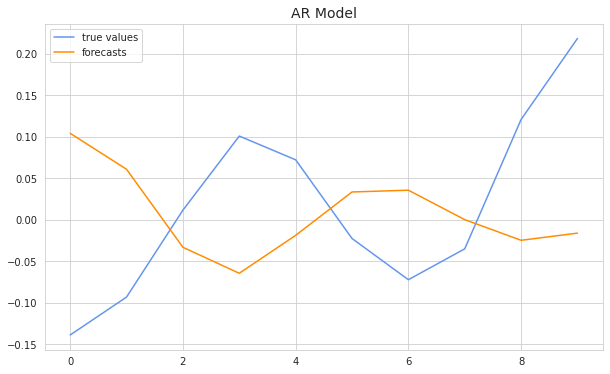

In [23]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
#Moving Average Model
model = ARIMA(train, order=(0,1,2))
MA_model = model.fit()

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, predictions)
print('MA MSE: {}'.format(round(ma_score,4)))

MA MSE: 0.0139

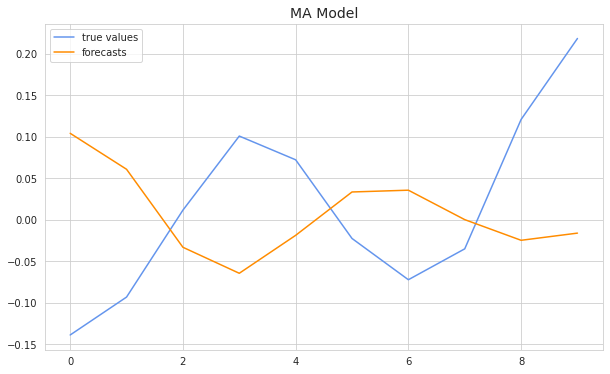

In [25]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [26]:
#ARIMA Model

model = ARIMA(train, order=(2,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score,4)))

ARIMA MSE: 0.0083


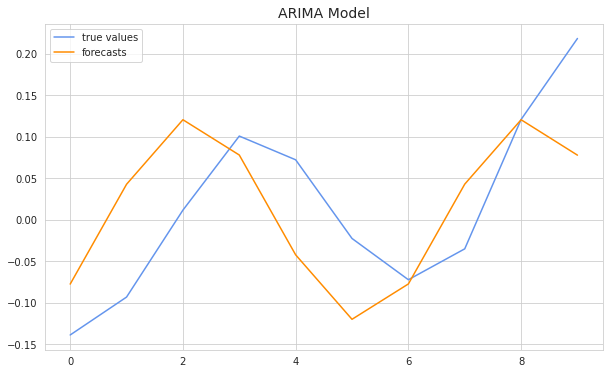

In [27]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [29]:
#Mean Squared Errors

errors = pd.DataFrame()
errors["Model"] = ["Persistence", "Autoregression", "Moving Average", "ARIMA"]
errors["MSE"] = [persistence_score, ar_score, 0.0139, arima_score]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Reds', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
ARIMA,0.008294
Persistence,0.008401
Moving Average,0.013900
Autoregression,0.021221
